In [1]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

## Large windows, with overlapping TOPMED deletions, and aggregated enhancer, exon, Chen variables 

In [4]:
import pandas as pd 

def read_labeled_examples(): 
  deletion_type = 'long' # see "STRATA" in experiments/germline-model/chen-et-al-2022/SNV_plus_SV_model.1.ipynb
  df = pd.read_csv(
    f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/large-windows-with-{deletion_type}-deletions-intersect-small-windows.aggregated.csv', 
    sep=',',
  )  
  return df 

LABELED_EXAMPLES = read_labeled_examples() 
LABELED_EXAMPLES

,chrom_large,start_large,end_large,number_of_overlapping_topmed_deletions,large_window-merged_deletion overlap,sum small_window overlaps merged_exon,sum small_window overlaps enhancer,sum small_window overlaps cpg_island,sum N_observed,sum enhancer count,sum small_window_enhancer_overlap_bps sum,sum N_mean_null_chen,sum N_variance_null_chen,sum large_window-small_window overlap,min negative new chen zscore,negative new chen zscore
0,chr1,2300000,2400000,4,60303,21,13,7,8177,14,9337,9794.714649,9794.714649,31000,-6.254506,-16.345794
1,chr1,2400000,2500000,2,74431,4,4,1,3093,4,1798,3866.251388,3866.251388,13000,-6.184123,-12.435855
2,chr1,2500000,2600000,1,2537,22,21,11,7172,24,17979,9340.543817,9340.543817,28000,-8.252822,-22.437895
3,chr1,2600000,2700000,3,37639,5,2,0,3669,2,1037,4376.598388,4376.598388,18000,-5.443687,-10.695928
4,chr1,2800000,2900000,6,63623,3,6,0,6183,6,2048,7225.712275,7225.712275,25000,-4.825689,-12.266599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24628,chr9,133900000,134000000,10,88278,3,25,3,7476,27,19573,9422.773366,9422.773366,32000,-5.783680,-20.055155
24629,chr9,134000000,134100000,2,100000,11,11,2,7910,12,6989,9103.134739,9103.134739,37000,-5.149057,-12.505297
24630,chr9,134200000,134300000,8,82201,5,25,0,10653,27,18569,13194.622097,13194.622097,47000,-5.052936,-22.126489
24631,chr9,134300000,134400000,0,0,1,18,2,5128,21,13587,6424.429486,6424.429486,22000,-6.073125,-16.174528


## SNV-only, SV-only, and SNV+SV classifiers 

In [18]:
import numpy as np 

def predict_exon_count_using_SNVs(df, SNV_parameter): 
  score = 'min negative new chen zscore' # TODO also try: "negative new chen zscore"
  df = df[[score, 'sum small_window overlaps merged_exon']].copy()
  df = df.rename(columns={'sum small_window overlaps merged_exon': 'observed exon count'})
  df['predicted exon count'] = np.exp(SNV_parameter * df[score])
  return df

predict_exon_count_using_SNVs(LABELED_EXAMPLES, SNV_parameter=-0.5)

,min negative new chen zscore,observed exon count,predicted exon count
0,-6.254506,21,22.811226
1,-6.184123,4,22.022426
2,-8.252822,22,61.955152
3,-5.443687,5,15.208330
4,-4.825689,3,11.165679
...,...,...,...
24628,-5.783680,3,18.026452
24629,-5.149057,11,13.125128
24630,-5.052936,5,12.509247
24631,-6.073125,1,20.833510


In [4]:
# TODO: continue from here 
# 1. predict exon count using SVs
# 2. predict exon count using SNVs and SVs
# 3. given predictions, compute r2 between predictions and observations, and plot predictions vs observations
# 4. repeat for all values of predictor parameters 
# 5. plot violin plot of r2 for each of the three predictors

def predict_constraint_using_SVs(df, deletion_count_threshold): 
  df = df[[
    'truly constrained', 
    'count SVTYPE'
  ]].copy()
  df['predicted to be constrained'] = df['count SVTYPE'] <= deletion_count_threshold
  return df

pd.set_option('display.max_rows', 10)

predict_constraint_using_SVs(LABELED_EXAMPLES, deletion_count_threshold=0)

,truly constrained,count SVTYPE,predicted to be constrained
0,False,1,False
1,False,1,False
2,False,1,False
3,True,0,True
4,False,2,False
...,...,...,...
1113,False,1,False
1114,False,1,False
1115,False,0,True
1116,False,1,False


In [5]:
def predict_constraint_using_voting_ensemble(df, zscore_threshold, deletion_count_threshold): 
  zscore = 'min negative_new_chen_score_window'
  df = df[[
    zscore, 
    'truly constrained', 
    'count SVTYPE'
  ]].copy()
  # majority voting ensemble (i.e. if both the SNV and SV model predict a region to be constrained, then it is predicted to be constrained)
  df['predicted to be constrained'] = (
    predict_constraint_using_SNVs(df, zscore_threshold)['predicted to be constrained'] & 
    predict_constraint_using_SVs(df, deletion_count_threshold)['predicted to be constrained']
  )
  # # "OR" ensemble (i.e. if either the SNV or SV model predicts a region to be constrained, then it is predicted to be constrained)
  # df['predicted to be constrained'] = (
  #   predict_constraint_using_SNVs(df, zscore_threshold)['predicted to be constrained'] |
  #   predict_constraint_using_SVs(df, deletion_count_threshold)['predicted to be constrained']
  # )
  return df 

pd.set_option('display.max_rows', 10)

predict_constraint_using_voting_ensemble(LABELED_EXAMPLES, zscore_threshold=-2, deletion_count_threshold=0)

,min negative_new_chen_score_window,truly constrained,count SVTYPE,predicted to be constrained
0,-1.995430,False,1,False
1,-0.454322,False,1,False
2,-1.825657,False,1,False
3,-3.432213,True,0,True
4,-1.271066,False,2,False
...,...,...,...,...
1113,0.367846,False,1,False
1114,1.470814,False,1,False
1115,0.594347,False,0,False
1116,-0.829970,False,1,False


In [6]:
def compute_precision_recall(df, log): 
  contingency_table = pd.crosstab(
    df['predicted to be constrained'], 
    df['truly constrained']
  )

  if log: print(contingency_table)

  tp = contingency_table.loc[True, True]
  fp = contingency_table.loc[True, False]
  fn = contingency_table.loc[False, True]
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)

  return precision, recall

def compute_precision_recall_using_SNVs(df, zscore_threshold, log=False): 
  if log: print(zscore_threshold)
  df = predict_constraint_using_SNVs(df, zscore_threshold)
  return compute_precision_recall(df, log)
  
compute_precision_recall_using_SNVs(LABELED_EXAMPLES, zscore_threshold=-3, log=True)

-3
truly constrained            False  True
predicted to be constrained             
False                          978   104
True                            22    14


(0.3888888888888889, 0.11864406779661017)

In [7]:
def compute_precision_recall_using_SVs(df, deletion_count_threshold, log=False): 
  if log: print(deletion_count_threshold)
  df = predict_constraint_using_SVs(df, deletion_count_threshold)
  return compute_precision_recall(df, log)
  
compute_precision_recall_using_SVs(LABELED_EXAMPLES, deletion_count_threshold=0, log=True)

0
truly constrained            False  True
predicted to be constrained             
False                          698    49
True                           302    69


(0.18598382749326145, 0.5847457627118644)

In [8]:
def compute_precision_recall_using_voting_ensemble(df, zscore_threshold, deletion_count_threshold, log=False): 
  if log: 
    print(zscore_threshold)
    print(deletion_count_threshold)
  df = predict_constraint_using_voting_ensemble(df, zscore_threshold, deletion_count_threshold)
  return compute_precision_recall(df, log)
  
compute_precision_recall_using_voting_ensemble(LABELED_EXAMPLES, zscore_threshold=-3, deletion_count_threshold=0, log=True)

-3
0
truly constrained            False  True
predicted to be constrained             
False                          989   107
True                            11    11


(0.5, 0.09322033898305085)

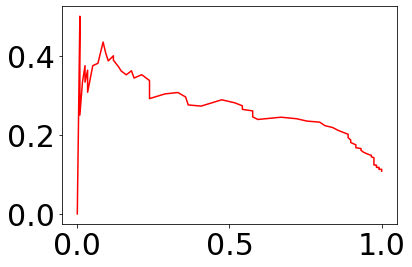

In [9]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set the font size
mpl.rcParams['font.size'] = 30

def plot_precision_recall_using_SNVs(df): 
  zscore_thresholds = np.arange(-6, 5.5, 0.1) 
  precision_recall = [
    compute_precision_recall_using_SNVs(df, zscore_threshold, log=False)
    for zscore_threshold in zscore_thresholds
  ]
  precisions, recalls = zip(*precision_recall)
  plt.plot(recalls, precisions, label='using SNVs', color='red')

plot_precision_recall_using_SNVs(LABELED_EXAMPLES)

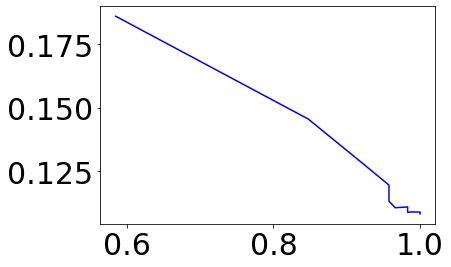

In [10]:
def plot_precision_recall_using_SVs(df): 
  deletion_count_thresholds = np.arange(0, 11, 1)
  precision_recall = [
    compute_precision_recall_using_SVs(df, deletion_count_threshold, log=False)
    for deletion_count_threshold in deletion_count_thresholds
  ]
  precisions, recalls = zip(*precision_recall)
  plt.plot(recalls, precisions, label='using SVs', color='blue')

plot_precision_recall_using_SVs(LABELED_EXAMPLES)

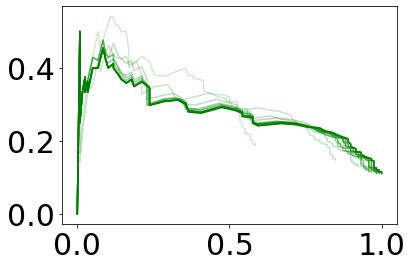

In [11]:
def plot_precision_recall_using_voting_ensemble(df): 
  zscore_thresholds = np.arange(-6, 5.5, 0.1) 
  deletion_count_thresholds = np.arange(0, 11, 1)
  alphas = np.logspace(-0.75, 0, len(deletion_count_thresholds))
  for index, (alpha, deletion_count_threshold) in enumerate(zip(alphas, deletion_count_thresholds)):
    precision_recall = [
      compute_precision_recall_using_voting_ensemble(df, zscore_threshold, deletion_count_threshold, log=False)
      for zscore_threshold in zscore_thresholds
    ]
    precisions, recalls = zip(*precision_recall)
    if index == 0 or index == len(deletion_count_thresholds) - 1: 
      plt.plot(recalls, precisions, label=f'using SNVs and SVs (majority-vote ensemble)\n(deletion-count threshold = {deletion_count_thresholds[index]})', color='green', alpha=alpha)
    else:
      plt.plot(recalls, precisions, color='green', alpha=alpha)

plot_precision_recall_using_voting_ensemble(LABELED_EXAMPLES)

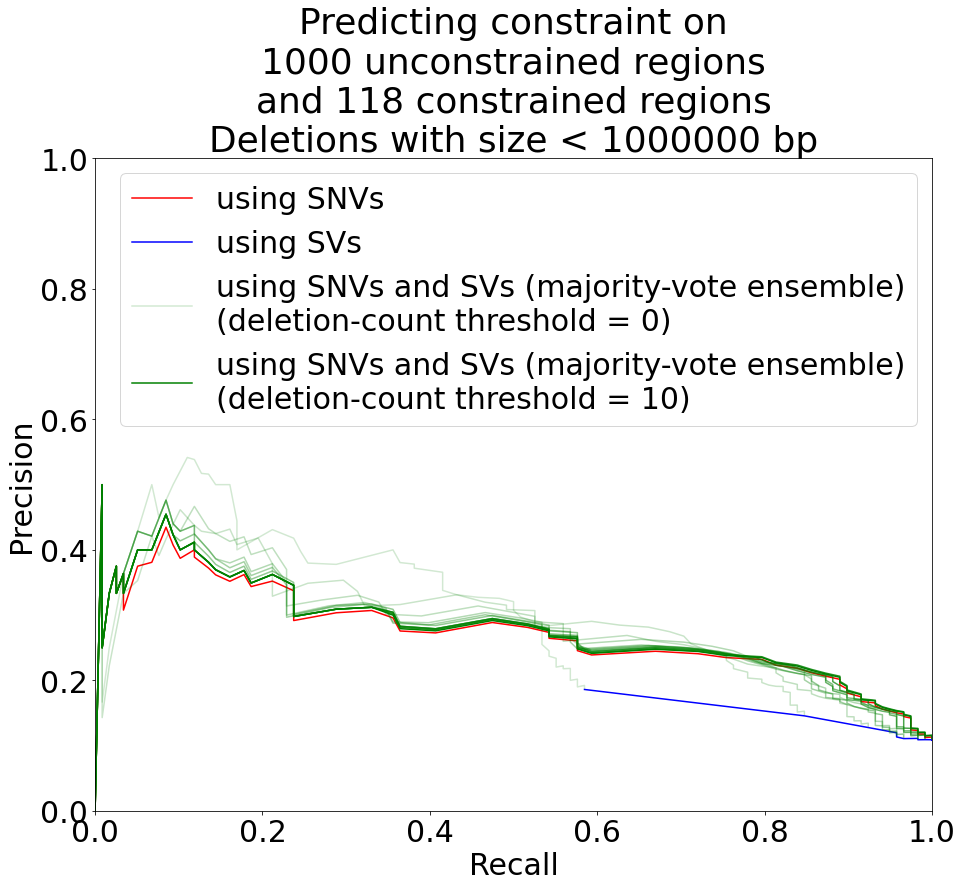

In [12]:
def plot_precision_recall_wrapper(df): 
  plot_precision_recall_using_SNVs(df)
  plot_precision_recall_using_SVs(df)
  plot_precision_recall_using_voting_ensemble(df)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend()
  fig = plt.gcf()
  fig.set_size_inches(15, 12)
  plt.xlim(0, 1)
  plt.ylim(0, 1)

  number_unconstrained_regions = df['truly constrained'].value_counts().loc[False]
  number_constrained_regions = df['truly constrained'].value_counts().loc[True]
  plt.title(
    'Predicting constraint on\n'
    f'{number_unconstrained_regions} unconstrained regions\n'
    f'and {number_constrained_regions} constrained regions\n'
    f'Deletions with size < {DELETION_SIZE_THRESHOLD} bp'
  )
  
plot_precision_recall_wrapper(LABELED_EXAMPLES)